In [7]:
from datetime import datetime
import numpy as np
import xgboost as xgb

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
from pipeline_v1.mb import MoodBoost
from pipeline_v1.optimizing import SubjectwiseCrossVal, MoodBoostOptimizer
from pipeline_v1.signal_pross import get_hr, min_max_scale
from pipeline_v1.truth import IeeeGroundTruth

## 1. Process and align RGB data from video with ground truth BVP data

In [4]:
truths = []
noisy_truths = []
dim_truths = []
bright_truths = []

for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3')  # we only use the first trial for each subject
    truth_noisy = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3_noise', noisy = True)
    truth_dim = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3_dim', dim = True)
    truth_bright = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3_bright', bright = True)
    
    truth.align_rgb_bvp()
    truth_noisy.align_rgb_bvp()
    truth_dim.align_rgb_bvp()
    truth_bright.align_rgb_bvp()

    truth.fill_nans()
    truth_noisy.fill_nans()
    truth_dim.fill_nans()
    truth_bright.fill_nans()

    truth.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth_noisy.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth_dim.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth_bright.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )

    truth.process_bvp()
    truth_noisy.process_bvp()
    truth_dim.process_bvp()
    truth_bright.process_bvp()

    truths.append(truth)
    noisy_truths.append(truth_noisy)
    dim_truths.append(truth_dim)
    bright_truths.append(truth_bright)

truths.extend(noisy_truths)
truths.extend(dim_truths)
truths.extend(bright_truths)

## 2. Train the model and validate using subject 7

In [9]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = MoodBoost(
    truths, random_state = None, loss_type = 'combined',
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642, 
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
)
mod.fit()

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 52320


On batch 1 of 5:
[0]	train-rmse:0.68644	train-hr_err:26.29714	test-rmse:0.83395	test-hr_err:54.85801
[5]	train-rmse:0.68989	train-hr_err:26.29714	test-rmse:0.83612	test-hr_err:53.13882
[10]	train-rmse:0.69333	train-hr_err:11.67292	test-rmse:0.83832	test-hr_err:35.18175
[15]	train-rmse:0.69679	train-hr_err:11.72197	test-rmse:0.84050	test-hr_err:39.89853
[20]	train-rmse:0.70028	train-hr_err:17.90456	test-rmse:0.84272	test-hr_err:38.26037
[25]	train-rmse:0.70379	train-hr_err:15.24063	test-rmse:0.84496	test-hr_err:34.66038
[30]	train-rmse:0.70734	train-hr_err:16.74648	test-rmse:0.84723	test-hr_err:34.83317
[35]	train-rmse:0.71095	train-hr_err:16.77134	test-rmse:0.84975	test-hr_err:33.89406
[37]	train-rmse:0.71243	train-hr_err:17.71121	test-rmse:0.85089	test-hr_err:35.44443
Fintuning...
[0]	train-rmse:1.15919	train-hr_err:17.48810	test-rmse:0.85021	test-hr_err:35.44443
[5]	train-rmse:1.15414	train-hr_err:21.91455	test-rmse:0.84680	test-hr_err:37.11433
[

## 2.5. Save the model

In [ ]:
# mod.save('moodboost.xgb')

## Print the model stats



MSE: 0.1031509980585441
HR error: 27.064050967347764
HR error squared: 1145.145979902906


Best test loss: 28.341845


Feature importances:
   feature  importance
0      f17   60.418598
1      f23   46.148483
2      f15   43.748993
3      f29   41.728706
4      f33   40.751972
5      f21   38.091187
6      f30   34.144203
7      f27   32.056305
8      f18   30.317673
9      f32   28.968126
10     f14   28.378559
11     f20   25.430229
12      f9   23.744909
13      f4   23.315535
14     f28   22.977627
15     f26   22.449566
16      f2   22.398462
17     f24   22.365486
18     f22   19.833586
19     f19   18.461372
20      f1   18.386044
21      f5   17.218422
22      f3   17.010857
23     f31   16.578846
24     f13   15.967474
25     f25   15.535028
26     f16   15.406364
27      f0    6.433545
28      f7    4.114053
29      f6    0.545662


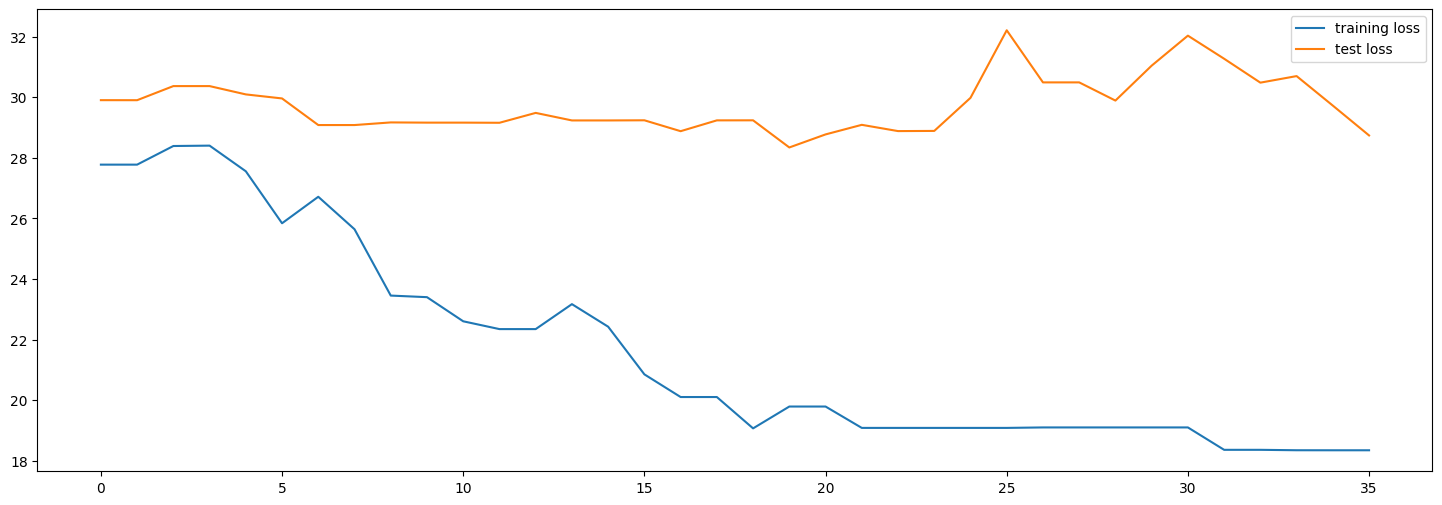

In [10]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_hr_loss()

## Plot the predicted signal versus its ground truth

peak memory: 440.18 MiB, increment: 0.06 MiB
Time elapsed: 0:00:00.059813
True HR: 49.10485933503836; Pred HR: 63.621301775147934


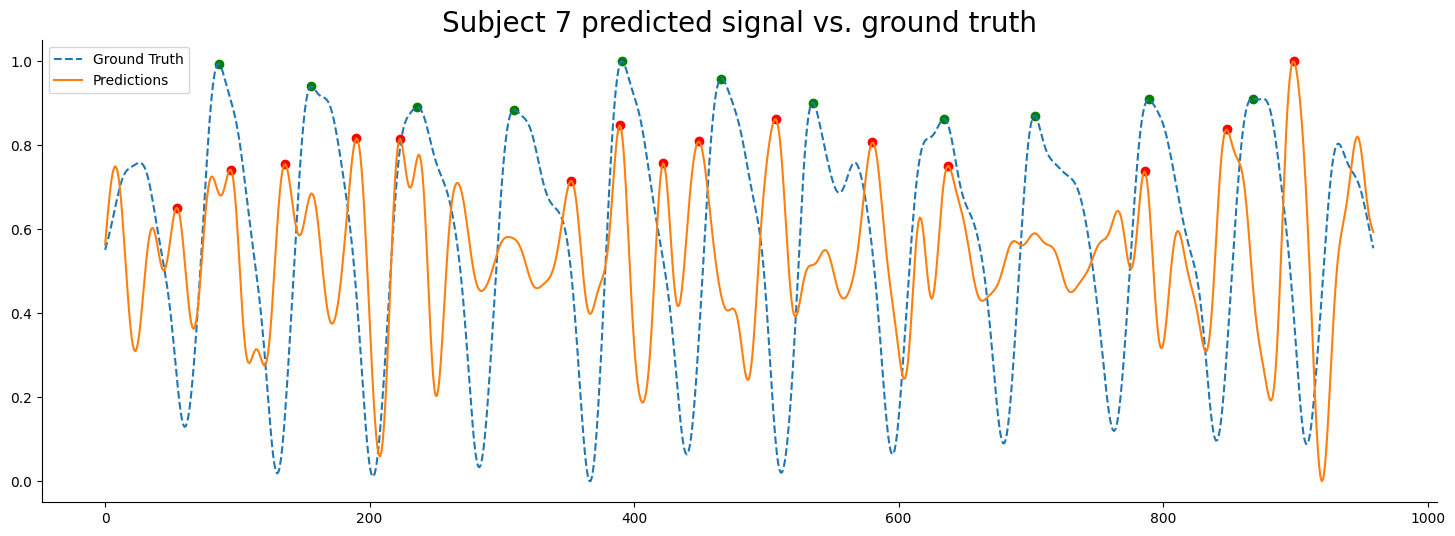

In [11]:
# beginning point from which to plot
beg = 3000
end = beg + 960  # we add 960 bc that's the period which HR error is calculated; it's also the amount of user video needed to calculate HR error (15s)

# prepare test subject data for ML, and give it the corresponding mem feats (8 mem feat, 12 skip amount)
data = test_subject_truth.prepare_data_for_ml(8, 12)

# get input data and target data
X = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

# get the model predictions in this method so that RAM usage is measured accurately
def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = mod.predict(X)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    elapsed_time = datetime.today() - t
    return targ, pred, elapsed_time

# measure the RAM usage of the model while also getting the predictions and processing both predictions and targets
%memit targ, pred, elapsed_time = measure_code_block()
print('Time elapsed:', elapsed_time)

# get the predicted and true peaks for each signal
pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

# create the plot
plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)

# modify plot appearance
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

# plot the peaks
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

# compute the predicted and true HR for this block
pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

## 4. Apply cross-validation to validate performance

Warning: Can take a little while

In [5]:
special_truths = {}
for i in range(1, 8):
    special_truths[i] = {
        'training': [truths[i - 1], noisy_truths[i - 1], dim_truths[i - 1], bright_truths[i - 1]],
        'testing': []
    }

rpm = 1
res = SubjectwiseCrossVal(
    special_truths, random_state = None, loss_type = 'combined', rounds_per_model = rpm,
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 1000, data_end = 4000,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642,
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, collect = True
)

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.83580	train-hr_err:33.45985	test-rmse:0.90528	test-hr_err:32.28342
[5]	train-rmse:0.83874	train-hr_err:33.45499	test-rmse:0.90709	test-hr_err:32.28697
[10]	train-rmse:0.84172	train-hr_err:33.45499	test-rmse:0.90892	test-hr_err:30.65203
[15]	train-rmse:0.84474	train-hr_err:32.01400	test-rmse:0.91078	test-hr_err:32.63949
[20]	train-rmse:0.84779	train-hr_err:32.38302	test-rmse:0.91267	test-hr_err:30.63044
[25]	train-rmse:0.85086	train-hr_err:31.14503	test-rmse:0.91457	test-hr_err:29.86324
[30]	train-rmse:0.85395	train-hr_err:30.67604	test-rmse:0.91652	test-hr_err:29.87251
[35]	train-rmse:0.85707	train-hr_err:30.49746	test-rmse:0.91850	test-hr_err:29.84436
[40]	train-rmse:0.86021	train-hr_err:30.52794	test-rmse:0.92049	test-hr_err:29.81181
[44]	train-rmse:0.86274	train-hr_err:30.06001	test-rmse:0.92204	test-hr_err:30.35898
Fintuning...
[0]	train-rmse:1.27402	train-hr_err:31.41461	test-rmse:0.92139	test-hr_err:30.39425


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.86387	train-hr_err:30.92005	test-rmse:0.80438	test-hr_err:24.33827
[5]	train-rmse:0.86647	train-hr_err:30.92005	test-rmse:0.80613	test-hr_err:24.33534
[10]	train-rmse:0.86908	train-hr_err:30.92005	test-rmse:0.80792	test-hr_err:24.11476
[15]	train-rmse:0.87172	train-hr_err:30.92005	test-rmse:0.80973	test-hr_err:24.11476
[20]	train-rmse:0.87436	train-hr_err:31.64322	test-rmse:0.81158	test-hr_err:23.92678
[25]	train-rmse:0.87700	train-hr_err:31.64322	test-rmse:0.81347	test-hr_err:23.57171
[30]	train-rmse:0.87965	train-hr_err:32.88290	test-rmse:0.81540	test-hr_err:23.21755
[35]	train-rmse:0.88233	train-hr_err:34.06215	test-rmse:0.81735	test-hr_err:23.32468
[40]	train-rmse:0.88502	train-hr_err:36.18014	test-rmse:0.81945	test-hr_err:23.80310
[45]	train-rmse:0.88771	train-hr_err:36.65091	test-rmse:0.82174	test-hr_err:22.55756
[50]	train-rmse:0.89042	train-hr_err:35.90089	test-rmse:0.82406	test-hr_err:22.35579
[55]	train-r

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.82253	train-hr_err:32.55872	test-rmse:0.82504	test-hr_err:31.68862
[5]	train-rmse:0.82608	train-hr_err:32.55872	test-rmse:0.82724	test-hr_err:31.68862
[10]	train-rmse:0.82967	train-hr_err:32.55872	test-rmse:0.82948	test-hr_err:31.89134
[15]	train-rmse:0.83330	train-hr_err:33.30115	test-rmse:0.83174	test-hr_err:31.44047
[20]	train-rmse:0.83682	train-hr_err:33.42563	test-rmse:0.83402	test-hr_err:34.29102
[25]	train-rmse:0.84037	train-hr_err:32.91118	test-rmse:0.83629	test-hr_err:35.06703
[30]	train-rmse:0.84396	train-hr_err:29.02397	test-rmse:0.83855	test-hr_err:33.58040
[31]	train-rmse:0.84468	train-hr_err:29.59890	test-rmse:0.83897	test-hr_err:34.66569
Fintuning...
[0]	train-rmse:1.26216	train-hr_err:26.12374	test-rmse:0.83837	test-hr_err:28.39520
[5]	train-rmse:1.25704	train-hr_err:30.70883	test-rmse:0.83539	test-hr_err:25.88410
[10]	train-rmse:1.25195	train-hr_err:29.78224	test-rmse:0.83245	test-hr_err:26.66290
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.89258	train-hr_err:15.51837	test-rmse:0.79754	test-hr_err:41.87112
[5]	train-rmse:0.89540	train-hr_err:15.52443	test-rmse:0.80016	test-hr_err:41.66046
[10]	train-rmse:0.89825	train-hr_err:15.52443	test-rmse:0.80281	test-hr_err:41.66046
[15]	train-rmse:0.90107	train-hr_err:15.00515	test-rmse:0.80527	test-hr_err:33.08369
[20]	train-rmse:0.90400	train-hr_err:11.00516	test-rmse:0.80776	test-hr_err:29.38072
[25]	train-rmse:0.90694	train-hr_err:11.65536	test-rmse:0.80964	test-hr_err:28.69656
[30]	train-rmse:0.90990	train-hr_err:11.43740	test-rmse:0.81200	test-hr_err:31.24048
[35]	train-rmse:0.91289	train-hr_err:12.00844	test-rmse:0.81454	test-hr_err:30.13930
[40]	train-rmse:0.91589	train-hr_err:12.49323	test-rmse:0.81717	test-hr_err:29.30734
[44]	train-rmse:0.91830	train-hr_err:12.74727	test-rmse:0.81940	test-hr_err:31.43191
Fintuning...
[0]	train-rmse:1.30542	train-hr_err:11.79109	test-rmse:0.81929	test-hr_err:32.22827


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.90872	train-hr_err:55.01908	test-rmse:0.81839	test-hr_err:27.99925
[5]	train-rmse:0.91123	train-hr_err:55.01908	test-rmse:0.82004	test-hr_err:28.31821
[10]	train-rmse:0.91361	train-hr_err:48.41296	test-rmse:0.82177	test-hr_err:30.23285
[15]	train-rmse:0.91598	train-hr_err:47.15988	test-rmse:0.82354	test-hr_err:29.64485
[20]	train-rmse:0.91837	train-hr_err:47.92950	test-rmse:0.82534	test-hr_err:32.10796
[22]	train-rmse:0.91933	train-hr_err:47.92950	test-rmse:0.82605	test-hr_err:32.23185
Fintuning...
[0]	train-rmse:1.28666	train-hr_err:48.10124	test-rmse:0.82545	test-hr_err:29.37074
[5]	train-rmse:1.28221	train-hr_err:48.83398	test-rmse:0.82250	test-hr_err:28.20989
[10]	train-rmse:1.27778	train-hr_err:46.16257	test-rmse:0.81960	test-hr_err:25.77073
[15]	train-rmse:1.27339	train-hr_err:41.92696	test-rmse:0.81673	test-hr_err:27.04173
[17]	train-rmse:1.27164	train-hr_err:42.26450	test-rmse:0.81559	test-hr_err:26.27586



/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.98587	train-hr_err:48.93664	test-rmse:0.88624	test-hr_err:37.30714
[5]	train-rmse:0.98875	train-hr_err:48.93664	test-rmse:0.88913	test-hr_err:37.30714
[10]	train-rmse:0.99166	train-hr_err:49.97984	test-rmse:0.89210	test-hr_err:36.94938
[15]	train-rmse:0.99459	train-hr_err:49.97984	test-rmse:0.89513	test-hr_err:36.94509
[20]	train-rmse:0.99755	train-hr_err:49.97984	test-rmse:0.89826	test-hr_err:36.94938
[25]	train-rmse:1.00053	train-hr_err:49.97984	test-rmse:0.90145	test-hr_err:36.94938
[30]	train-rmse:1.00353	train-hr_err:49.97984	test-rmse:0.90472	test-hr_err:36.94938
[31]	train-rmse:1.00414	train-hr_err:49.97984	test-rmse:0.90538	test-hr_err:36.94938
Fintuning...
[0]	train-rmse:1.37103	train-hr_err:49.46808	test-rmse:0.90453	test-hr_err:35.90843
[5]	train-rmse:1.36616	train-hr_err:47.84433	test-rmse:0.90036	test-hr_err:37.04664
[8]	train-rmse:1.36325	train-hr_err:46.20569	test-rmse:0.89791	test-hr_err:36.86594




/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.92437	train-hr_err:29.20754	test-rmse:0.88130	test-hr_err:35.91344
[5]	train-rmse:0.92726	train-hr_err:30.05987	test-rmse:0.88334	test-hr_err:35.70483
[10]	train-rmse:0.93017	train-hr_err:30.05273	test-rmse:0.88542	test-hr_err:35.70483
[15]	train-rmse:0.93310	train-hr_err:30.05273	test-rmse:0.88752	test-hr_err:35.70483
[17]	train-rmse:0.93429	train-hr_err:30.05273	test-rmse:0.88837	test-hr_err:35.70483
Fintuning...
[0]	train-rmse:1.29942	train-hr_err:29.53174	test-rmse:0.88797	test-hr_err:35.80982
[5]	train-rmse:1.29483	train-hr_err:28.58327	test-rmse:0.88596	test-hr_err:34.36239
[10]	train-rmse:1.29027	train-hr_err:28.11112	test-rmse:0.88399	test-hr_err:35.32348
[13]	train-rmse:1.28755	train-hr_err:23.51329	test-rmse:0.88283	test-hr_err:35.84611


On batch 2 of 5:
[0]	train-rmse:0.81008	train-hr_err:23.32007	test-rmse:0.88287	test-hr_err:33.74371
[5]	train-rmse:0.81310	train-hr_err:26.37863	test-rmse:0.88501	test-

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.77502	train-hr_err:29.50364	test-rmse:0.94339	test-hr_err:42.73725
[5]	train-rmse:0.77785	train-hr_err:29.50364	test-rmse:0.94448	test-hr_err:42.73725
[10]	train-rmse:0.78072	train-hr_err:32.47377	test-rmse:0.94561	test-hr_err:42.73725
[15]	train-rmse:0.78361	train-hr_err:32.47377	test-rmse:0.94678	test-hr_err:42.73725
Fintuning...
[0]	train-rmse:1.18364	train-hr_err:29.96475	test-rmse:0.94664	test-hr_err:42.89043
[5]	train-rmse:1.17896	train-hr_err:27.54080	test-rmse:0.94478	test-hr_err:41.27785
[10]	train-rmse:1.17432	train-hr_err:27.39146	test-rmse:0.94295	test-hr_err:47.18721
[11]	train-rmse:1.17339	train-hr_err:27.72311	test-rmse:0.94259	test-hr_err:46.33145


On batch 2 of 5:
[0]	train-rmse:0.87101	train-hr_err:28.54088	test-rmse:0.94292	test-hr_err:46.65878
[5]	train-rmse:0.87385	train-hr_err:23.98595	test-rmse:0.94465	test-hr_err:36.36275
[10]	train-rmse:0.87672	train-hr_err:24.30845	test-rmse:0.94658	test-

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.80696	train-hr_err:33.14458	test-rmse:0.82216	test-hr_err:33.74405
[5]	train-rmse:0.81035	train-hr_err:33.14458	test-rmse:0.82437	test-hr_err:33.74405
[10]	train-rmse:0.81376	train-hr_err:33.14458	test-rmse:0.82661	test-hr_err:33.74405
[15]	train-rmse:0.81720	train-hr_err:32.30221	test-rmse:0.82896	test-hr_err:34.89059
[20]	train-rmse:0.82066	train-hr_err:32.83638	test-rmse:0.83138	test-hr_err:34.59945
[25]	train-rmse:0.82414	train-hr_err:33.45174	test-rmse:0.83384	test-hr_err:36.55415
[27]	train-rmse:0.82554	train-hr_err:32.43223	test-rmse:0.83484	test-hr_err:35.91729
Fintuning...
[0]	train-rmse:1.24067	train-hr_err:32.21408	test-rmse:0.83419	test-hr_err:34.52224
[5]	train-rmse:1.23565	train-hr_err:33.10799	test-rmse:0.83097	test-hr_err:34.41455
[10]	train-rmse:1.23065	train-hr_err:29.61727	test-rmse:0.82780	test-hr_err:34.83174
[12]	train-rmse:1.22866	train-hr_err:29.66031	test-rmse:0.82654	test-hr_err:35.29574



/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.78183	train-hr_err:31.43612	test-rmse:0.93782	test-hr_err:37.84654
[5]	train-rmse:0.78490	train-hr_err:29.66565	test-rmse:0.94034	test-hr_err:42.91175
[10]	train-rmse:0.78800	train-hr_err:31.01930	test-rmse:0.94289	test-hr_err:43.57864
[15]	train-rmse:0.79112	train-hr_err:31.61625	test-rmse:0.94551	test-hr_err:41.22710
[18]	train-rmse:0.79301	train-hr_err:30.82167	test-rmse:0.94714	test-hr_err:43.45115
Fintuning...
[0]	train-rmse:1.20113	train-hr_err:28.36311	test-rmse:0.94650	test-hr_err:47.37288
[5]	train-rmse:1.19632	train-hr_err:21.04160	test-rmse:0.94334	test-hr_err:47.14367
[10]	train-rmse:1.19154	train-hr_err:19.97002	test-rmse:0.94022	test-hr_err:40.37197
[15]	train-rmse:1.18679	train-hr_err:23.70142	test-rmse:0.93715	test-hr_err:40.84036
[20]	train-rmse:1.18206	train-hr_err:21.47609	test-rmse:0.93413	test-hr_err:42.11252


On batch 2 of 5:
[0]	train-rmse:0.87040	train-hr_err:40.27128	test-rmse:0.93388	test

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.92925	train-hr_err:22.91376	test-rmse:0.90406	test-hr_err:41.60550
[5]	train-rmse:0.93238	train-hr_err:22.91376	test-rmse:0.90608	test-hr_err:41.60550
[10]	train-rmse:0.93553	train-hr_err:22.91906	test-rmse:0.90812	test-hr_err:40.25882
[15]	train-rmse:0.93871	train-hr_err:24.23474	test-rmse:0.91019	test-hr_err:41.45172
[20]	train-rmse:0.94188	train-hr_err:26.14314	test-rmse:0.91228	test-hr_err:41.07452
[25]	train-rmse:0.94507	train-hr_err:26.71507	test-rmse:0.91440	test-hr_err:40.85097
[27]	train-rmse:0.94636	train-hr_err:27.84001	test-rmse:0.91526	test-hr_err:40.95406
Fintuning...
[0]	train-rmse:1.31244	train-hr_err:24.53564	test-rmse:0.91466	test-hr_err:40.90406
[5]	train-rmse:1.30742	train-hr_err:24.11109	test-rmse:0.91169	test-hr_err:39.54766
[10]	train-rmse:1.30242	train-hr_err:19.65966	test-rmse:0.90876	test-hr_err:37.58930
[15]	train-rmse:1.29745	train-hr_err:22.35798	test-rmse:0.90588	test-hr_err:34.56517
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.85917	train-hr_err:27.28682	test-rmse:0.96419	test-hr_err:26.93054
[5]	train-rmse:0.86159	train-hr_err:26.03452	test-rmse:0.96576	test-hr_err:26.98678
[10]	train-rmse:0.86403	train-hr_err:26.52721	test-rmse:0.96735	test-hr_err:27.31530
[15]	train-rmse:0.86648	train-hr_err:26.52721	test-rmse:0.96897	test-hr_err:28.13487
[18]	train-rmse:0.86797	train-hr_err:26.51870	test-rmse:0.96996	test-hr_err:27.69488
Fintuning...
[0]	train-rmse:1.23679	train-hr_err:25.86274	test-rmse:0.96978	test-hr_err:25.12983
[5]	train-rmse:1.23235	train-hr_err:30.31292	test-rmse:0.96722	test-hr_err:27.56721
[8]	train-rmse:1.22971	train-hr_err:41.83993	test-rmse:0.96571	test-hr_err:29.98124


On batch 2 of 5:
[0]	train-rmse:0.89849	train-hr_err:31.28521	test-rmse:0.96611	test-hr_err:28.92571
[5]	train-rmse:0.90115	train-hr_err:23.37789	test-rmse:0.96814	test-hr_err:21.32420
[10]	train-rmse:0.90382	train-hr_err:24.12409	test-rmse:0.97021	test-h

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.88321	train-hr_err:38.10604	test-rmse:0.91667	test-hr_err:47.49078
[5]	train-rmse:0.88605	train-hr_err:38.10604	test-rmse:0.91888	test-hr_err:47.49078
[10]	train-rmse:0.88891	train-hr_err:38.10604	test-rmse:0.92113	test-hr_err:47.49078
[15]	train-rmse:0.89180	train-hr_err:38.11452	test-rmse:0.92340	test-hr_err:47.49078
[16]	train-rmse:0.89238	train-hr_err:38.11452	test-rmse:0.92386	test-hr_err:47.49078
Fintuning...
[0]	train-rmse:1.26046	train-hr_err:36.78932	test-rmse:0.92326	test-hr_err:47.48797
[5]	train-rmse:1.25600	train-hr_err:36.08585	test-rmse:0.92032	test-hr_err:45.21948
[10]	train-rmse:1.25156	train-hr_err:31.31490	test-rmse:0.91741	test-hr_err:44.63990
[15]	train-rmse:1.24716	train-hr_err:30.98651	test-rmse:0.91453	test-hr_err:44.74630
[20]	train-rmse:1.24279	train-hr_err:32.26794	test-rmse:0.91169	test-hr_err:43.43772
[25]	train-rmse:1.23844	train-hr_err:27.43565	test-rmse:0.90889	test-hr_err:43.71201
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.86969	train-hr_err:26.11654	test-rmse:0.94131	test-hr_err:33.82556
[5]	train-rmse:0.87260	train-hr_err:26.11654	test-rmse:0.94335	test-hr_err:33.77582
[10]	train-rmse:0.87553	train-hr_err:25.64716	test-rmse:0.94542	test-hr_err:34.00185
[15]	train-rmse:0.87849	train-hr_err:25.64716	test-rmse:0.94752	test-hr_err:34.43552
[18]	train-rmse:0.88028	train-hr_err:25.65770	test-rmse:0.94880	test-hr_err:34.43552
Fintuning...
[0]	train-rmse:1.25312	train-hr_err:26.17308	test-rmse:0.94835	test-hr_err:29.89658
[5]	train-rmse:1.24858	train-hr_err:25.81830	test-rmse:0.94614	test-hr_err:30.42569
[10]	train-rmse:1.24407	train-hr_err:26.03934	test-rmse:0.94396	test-hr_err:30.06024
[15]	train-rmse:1.23959	train-hr_err:26.27649	test-rmse:0.94182	test-hr_err:31.36309
[17]	train-rmse:1.23780	train-hr_err:27.66934	test-rmse:0.94098	test-hr_err:31.14357


On batch 2 of 5:
[0]	train-rmse:0.96484	train-hr_err:36.57431	test-rmse:0.94131	test

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.97514	train-hr_err:27.24930	test-rmse:0.92899	test-hr_err:40.96358
[5]	train-rmse:0.97732	train-hr_err:27.24930	test-rmse:0.93080	test-hr_err:41.71240
[10]	train-rmse:0.97952	train-hr_err:26.57631	test-rmse:0.93264	test-hr_err:40.65181
[15]	train-rmse:0.98173	train-hr_err:24.64723	test-rmse:0.93451	test-hr_err:42.85535
[20]	train-rmse:0.98400	train-hr_err:22.99777	test-rmse:0.93642	test-hr_err:42.70956
[25]	train-rmse:0.98644	train-hr_err:24.76415	test-rmse:0.93841	test-hr_err:37.10556
[30]	train-rmse:0.98883	train-hr_err:26.82871	test-rmse:0.94026	test-hr_err:34.46231
[35]	train-rmse:0.99127	train-hr_err:27.23034	test-rmse:0.94218	test-hr_err:35.23721
[40]	train-rmse:0.99371	train-hr_err:24.91377	test-rmse:0.94417	test-hr_err:35.48716
[45]	train-rmse:0.99618	train-hr_err:22.69383	test-rmse:0.94607	test-hr_err:34.88821
[50]	train-rmse:0.99873	train-hr_err:26.91272	test-rmse:0.94807	test-hr_err:34.66634
[55]	train-r

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 72000


On batch 1 of 5:
[0]	train-rmse:0.83827	train-hr_err:50.46379	test-rmse:0.86220	test-hr_err:40.33232
[5]	train-rmse:0.84137	train-hr_err:50.46379	test-rmse:0.86426	test-hr_err:40.33232
[10]	train-rmse:0.84450	train-hr_err:50.46379	test-rmse:0.86636	test-hr_err:40.33232
[15]	train-rmse:0.84764	train-hr_err:50.31598	test-rmse:0.86852	test-hr_err:39.44391
[20]	train-rmse:0.85080	train-hr_err:49.62712	test-rmse:0.87073	test-hr_err:39.45417
[25]	train-rmse:0.85399	train-hr_err:50.09828	test-rmse:0.87297	test-hr_err:39.27434
[30]	train-rmse:0.85721	train-hr_err:49.04527	test-rmse:0.87525	test-hr_err:39.02902
[35]	train-rmse:0.86044	train-hr_err:49.04527	test-rmse:0.87757	test-hr_err:38.50865
[40]	train-rmse:0.86370	train-hr_err:49.48507	test-rmse:0.87995	test-hr_err:38.89597
[45]	train-rmse:0.86699	train-hr_err:48.31458	test-rmse:0.88237	test-hr_err:38.28099
[50]	train-rmse:0.87031	train-hr_err:48.14929	test-rmse:0.88482	test-hr_err:37.92294
[55]	train-r

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 72000


On batch 1 of 5:
[0]	train-rmse:0.75117	train-hr_err:40.42393	test-rmse:0.78535	test-hr_err:32.39550
[5]	train-rmse:0.75447	train-hr_err:33.73429	test-rmse:0.78776	test-hr_err:32.90742
[10]	train-rmse:0.75782	train-hr_err:40.73444	test-rmse:0.79022	test-hr_err:33.47893
[15]	train-rmse:0.76119	train-hr_err:41.37027	test-rmse:0.79273	test-hr_err:33.16953
[16]	train-rmse:0.76187	train-hr_err:41.37027	test-rmse:0.79324	test-hr_err:33.13108
Fintuning...
[0]	train-rmse:1.18149	train-hr_err:41.39348	test-rmse:0.79256	test-hr_err:33.25816
[5]	train-rmse:1.17652	train-hr_err:28.79699	test-rmse:0.78918	test-hr_err:34.55167
[10]	train-rmse:1.17161	train-hr_err:21.17290	test-rmse:0.78578	test-hr_err:30.73978
[15]	train-rmse:1.16676	train-hr_err:27.81073	test-rmse:0.78238	test-hr_err:29.20499
[20]	train-rmse:1.16191	train-hr_err:30.95183	test-rmse:0.77904	test-hr_err:28.03662
[25]	train-rmse:1.15711	train-hr_err:31.14269	test-rmse:0.77570	test-hr_err:25.09760
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 72000


On batch 1 of 5:
[0]	train-rmse:0.94329	train-hr_err:61.49395	test-rmse:0.85099	test-hr_err:54.52317
[5]	train-rmse:0.94588	train-hr_err:61.49395	test-rmse:0.85376	test-hr_err:54.52317
[10]	train-rmse:0.94850	train-hr_err:61.49395	test-rmse:0.85660	test-hr_err:54.52317
[15]	train-rmse:0.95113	train-hr_err:61.49395	test-rmse:0.85952	test-hr_err:54.52317
[16]	train-rmse:0.95166	train-hr_err:61.49395	test-rmse:0.86011	test-hr_err:54.52317
Fintuning...
[0]	train-rmse:1.30548	train-hr_err:61.49395	test-rmse:0.85936	test-hr_err:48.61918
[5]	train-rmse:1.30084	train-hr_err:61.02451	test-rmse:0.85564	test-hr_err:46.20555
[10]	train-rmse:1.29624	train-hr_err:57.72821	test-rmse:0.85201	test-hr_err:40.77187
[15]	train-rmse:1.29170	train-hr_err:54.63124	test-rmse:0.84849	test-hr_err:43.40804
[18]	train-rmse:1.28897	train-hr_err:56.11222	test-rmse:0.84639	test-hr_err:42.78369


On batch 2 of 5:
[0]	train-rmse:0.73970	train-hr_err:51.54093	test-rmse:0.84687	test

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 72000


On batch 1 of 5:
[0]	train-rmse:0.86871	train-hr_err:29.62225	test-rmse:0.82336	test-hr_err:31.22464
[5]	train-rmse:0.87137	train-hr_err:29.62225	test-rmse:0.82570	test-hr_err:31.22464
[10]	train-rmse:0.87406	train-hr_err:30.02414	test-rmse:0.82807	test-hr_err:31.64781
[15]	train-rmse:0.87677	train-hr_err:31.46030	test-rmse:0.83047	test-hr_err:31.63304
Fintuning...
[0]	train-rmse:1.25503	train-hr_err:31.77113	test-rmse:0.83030	test-hr_err:31.15840
[5]	train-rmse:1.25053	train-hr_err:28.55203	test-rmse:0.82705	test-hr_err:31.45366
[9]	train-rmse:1.24695	train-hr_err:25.50072	test-rmse:0.82446	test-hr_err:33.11497


On batch 2 of 5:
[0]	train-rmse:0.88953	train-hr_err:25.58507	test-rmse:0.82409	test-hr_err:28.34910
[5]	train-rmse:0.89195	train-hr_err:30.27581	test-rmse:0.82547	test-hr_err:25.59521
[10]	train-rmse:0.89439	train-hr_err:23.70485	test-rmse:0.82687	test-hr_err:19.97038
[15]	train-rmse:0.89686	train-hr_err:28.97045	test-rmse:0.82830	test-h

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 72000


On batch 1 of 5:
[0]	train-rmse:0.85042	train-hr_err:25.95831	test-rmse:0.80877	test-hr_err:33.26820
[5]	train-rmse:0.85309	train-hr_err:26.45962	test-rmse:0.81056	test-hr_err:33.08961
[10]	train-rmse:0.85579	train-hr_err:25.95831	test-rmse:0.81238	test-hr_err:33.39107
[15]	train-rmse:0.85848	train-hr_err:26.33070	test-rmse:0.81409	test-hr_err:32.65955
[20]	train-rmse:0.86120	train-hr_err:28.14360	test-rmse:0.81580	test-hr_err:33.74523
[25]	train-rmse:0.86394	train-hr_err:25.07392	test-rmse:0.81753	test-hr_err:34.82453
[30]	train-rmse:0.86671	train-hr_err:25.41079	test-rmse:0.81932	test-hr_err:34.36580
Fintuning...
[0]	train-rmse:1.26446	train-hr_err:25.97416	test-rmse:0.81902	test-hr_err:28.06532
[5]	train-rmse:1.25960	train-hr_err:26.08401	test-rmse:0.81570	test-hr_err:29.20710
[8]	train-rmse:1.25669	train-hr_err:26.39810	test-rmse:0.81373	test-hr_err:28.66772


On batch 2 of 5:
[0]	train-rmse:0.89636	train-hr_err:29.46464	test-rmse:0.81410	test-

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.93861	train-hr_err:25.57742	test-rmse:0.87312	test-hr_err:28.33375
[5]	train-rmse:0.94167	train-hr_err:25.20841	test-rmse:0.87525	test-hr_err:27.41963
[10]	train-rmse:0.94475	train-hr_err:24.23975	test-rmse:0.87740	test-hr_err:26.87430
[15]	train-rmse:0.94785	train-hr_err:24.12008	test-rmse:0.87959	test-hr_err:27.42817
[20]	train-rmse:0.95098	train-hr_err:23.63906	test-rmse:0.88183	test-hr_err:26.78616
[25]	train-rmse:0.95413	train-hr_err:23.63305	test-rmse:0.88410	test-hr_err:27.67920
[28]	train-rmse:0.95603	train-hr_err:23.63305	test-rmse:0.88548	test-hr_err:27.85416
Fintuning...
[0]	train-rmse:1.32915	train-hr_err:23.35313	test-rmse:0.88482	test-hr_err:28.29550
[5]	train-rmse:1.32441	train-hr_err:23.12216	test-rmse:0.88154	test-hr_err:27.45890
[10]	train-rmse:1.31970	train-hr_err:22.44143	test-rmse:0.87830	test-hr_err:26.11388
[15]	train-rmse:1.31503	train-hr_err:23.73177	test-rmse:0.87510	test-hr_err:23.15706
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.83808	train-hr_err:28.62371	test-rmse:0.89203	test-hr_err:45.48549
[5]	train-rmse:0.84120	train-hr_err:29.15973	test-rmse:0.89413	test-hr_err:45.48549
[10]	train-rmse:0.84435	train-hr_err:29.65068	test-rmse:0.89626	test-hr_err:45.24186
[15]	train-rmse:0.84753	train-hr_err:29.65068	test-rmse:0.89843	test-hr_err:45.24186
[20]	train-rmse:0.85073	train-hr_err:29.65068	test-rmse:0.90063	test-hr_err:45.24186
[25]	train-rmse:0.85396	train-hr_err:29.67859	test-rmse:0.90293	test-hr_err:45.24186
[26]	train-rmse:0.85461	train-hr_err:29.67859	test-rmse:0.90339	test-hr_err:45.24186
Fintuning...
[0]	train-rmse:1.25431	train-hr_err:29.00485	test-rmse:0.90275	test-hr_err:44.88299
[5]	train-rmse:1.24949	train-hr_err:27.77789	test-rmse:0.89956	test-hr_err:44.30782
[10]	train-rmse:1.24470	train-hr_err:26.37418	test-rmse:0.89645	test-hr_err:46.03291
[12]	train-rmse:1.24278	train-hr_err:26.37418	test-rmse:0.89526	test-hr_err:46.06142



/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.95070	train-hr_err:48.86949	test-rmse:0.93798	test-hr_err:56.76344
[5]	train-rmse:0.95327	train-hr_err:48.86949	test-rmse:0.93988	test-hr_err:56.76344
[10]	train-rmse:0.95585	train-hr_err:48.86949	test-rmse:0.94180	test-hr_err:56.76674
[15]	train-rmse:0.95846	train-hr_err:48.87555	test-rmse:0.94375	test-hr_err:56.77005
[16]	train-rmse:0.95898	train-hr_err:48.88159	test-rmse:0.94414	test-hr_err:56.76674
Fintuning...
[0]	train-rmse:1.30968	train-hr_err:48.07152	test-rmse:0.94359	test-hr_err:60.14346
[5]	train-rmse:1.30513	train-hr_err:43.84318	test-rmse:0.94084	test-hr_err:57.95092
[10]	train-rmse:1.30061	train-hr_err:42.47711	test-rmse:0.93813	test-hr_err:58.91729
[11]	train-rmse:1.29971	train-hr_err:42.47711	test-rmse:0.93759	test-hr_err:58.91729


On batch 2 of 5:
[0]	train-rmse:0.74559	train-hr_err:24.69761	test-rmse:0.93749	test-hr_err:36.10308
[5]	train-rmse:0.74877	train-hr_err:23.03359	test-rmse:0.93972	test-

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.76155	train-hr_err:30.13504	test-rmse:0.91761	test-hr_err:23.32015
[5]	train-rmse:0.76492	train-hr_err:30.12690	test-rmse:0.91997	test-hr_err:23.32015
[10]	train-rmse:0.76832	train-hr_err:30.12690	test-rmse:0.92236	test-hr_err:23.32015
[15]	train-rmse:0.77176	train-hr_err:30.12690	test-rmse:0.92478	test-hr_err:23.32015
[16]	train-rmse:0.77245	train-hr_err:30.12690	test-rmse:0.92527	test-hr_err:23.32015
Fintuning...
[0]	train-rmse:1.19010	train-hr_err:31.17155	test-rmse:0.92465	test-hr_err:23.52654
[5]	train-rmse:1.18507	train-hr_err:16.20915	test-rmse:0.92156	test-hr_err:22.44876
[10]	train-rmse:1.18006	train-hr_err:17.48500	test-rmse:0.91834	test-hr_err:21.40736
[15]	train-rmse:1.17510	train-hr_err:14.72833	test-rmse:0.91516	test-hr_err:17.38716
[20]	train-rmse:1.17016	train-hr_err:14.35590	test-rmse:0.91206	test-hr_err:17.07355
[25]	train-rmse:1.16527	train-hr_err:14.37602	test-rmse:0.90894	test-hr_err:17.18121
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.90322	train-hr_err:24.97380	test-rmse:0.94161	test-hr_err:36.44677
[5]	train-rmse:0.90653	train-hr_err:24.97380	test-rmse:0.94407	test-hr_err:35.05348
[10]	train-rmse:0.90986	train-hr_err:23.41845	test-rmse:0.94656	test-hr_err:35.07370
[15]	train-rmse:0.91322	train-hr_err:23.41845	test-rmse:0.94906	test-hr_err:35.07370
[20]	train-rmse:0.91660	train-hr_err:23.41845	test-rmse:0.95151	test-hr_err:34.85280
[25]	train-rmse:0.91999	train-hr_err:25.01394	test-rmse:0.95401	test-hr_err:33.00489
[30]	train-rmse:0.92340	train-hr_err:21.20004	test-rmse:0.95654	test-hr_err:34.29927
[35]	train-rmse:0.92683	train-hr_err:19.36305	test-rmse:0.95913	test-hr_err:33.51205
[40]	train-rmse:0.93029	train-hr_err:19.17951	test-rmse:0.96153	test-hr_err:33.53471
[42]	train-rmse:0.93169	train-hr_err:23.14910	test-rmse:0.96248	test-hr_err:32.71858
Fintuning...
[0]	train-rmse:1.33353	train-hr_err:24.08433	test-rmse:0.96184	test-hr_err:30.70315


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.90389	train-hr_err:44.52007	test-rmse:0.79229	test-hr_err:45.95374
[5]	train-rmse:0.90687	train-hr_err:45.05537	test-rmse:0.79497	test-hr_err:46.07699
[10]	train-rmse:0.90988	train-hr_err:45.05537	test-rmse:0.79767	test-hr_err:46.07699
[15]	train-rmse:0.91292	train-hr_err:45.05537	test-rmse:0.80042	test-hr_err:46.07699
[20]	train-rmse:0.91604	train-hr_err:37.07356	test-rmse:0.80320	test-hr_err:44.93270
[25]	train-rmse:0.91920	train-hr_err:35.34014	test-rmse:0.80599	test-hr_err:37.11271
[30]	train-rmse:0.92240	train-hr_err:36.03098	test-rmse:0.80875	test-hr_err:37.06107
[35]	train-rmse:0.92561	train-hr_err:34.13492	test-rmse:0.81156	test-hr_err:38.67411
[40]	train-rmse:0.92884	train-hr_err:39.53391	test-rmse:0.81464	test-hr_err:36.59354
[45]	train-rmse:0.93207	train-hr_err:37.76888	test-rmse:0.81778	test-hr_err:41.49518
[50]	train-rmse:0.93532	train-hr_err:41.41944	test-rmse:0.82098	test-hr_err:38.82694
[55]	train-r

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.91070	train-hr_err:54.61498	test-rmse:0.92270	test-hr_err:56.61122
[5]	train-rmse:0.91362	train-hr_err:54.61498	test-rmse:0.92494	test-hr_err:56.61122
[10]	train-rmse:0.91656	train-hr_err:54.61498	test-rmse:0.92721	test-hr_err:56.61122
[15]	train-rmse:0.91953	train-hr_err:54.61498	test-rmse:0.92951	test-hr_err:56.61122
[16]	train-rmse:0.92013	train-hr_err:54.61498	test-rmse:0.92997	test-hr_err:56.61122
Fintuning...
[0]	train-rmse:1.28609	train-hr_err:53.56420	test-rmse:0.92937	test-hr_err:52.62758
[5]	train-rmse:1.28120	train-hr_err:54.60896	test-rmse:0.92638	test-hr_err:57.06230
[8]	train-rmse:1.27828	train-hr_err:49.11392	test-rmse:0.92460	test-hr_err:57.85806


On batch 2 of 5:
[0]	train-rmse:0.80020	train-hr_err:38.83093	test-rmse:0.92444	test-hr_err:48.39842
[5]	train-rmse:0.80337	train-hr_err:36.61699	test-rmse:0.92661	test-hr_err:37.41957
[10]	train-rmse:0.80657	train-hr_err:35.52598	test-rmse:0.92885	test-h

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.84200	train-hr_err:32.80022	test-rmse:0.82667	test-hr_err:39.94918
[5]	train-rmse:0.84528	train-hr_err:32.80022	test-rmse:0.82829	test-hr_err:39.94918
[10]	train-rmse:0.84859	train-hr_err:32.80022	test-rmse:0.83003	test-hr_err:37.93980
[15]	train-rmse:0.85193	train-hr_err:32.80022	test-rmse:0.83185	test-hr_err:38.42636
[20]	train-rmse:0.85530	train-hr_err:32.78516	test-rmse:0.83372	test-hr_err:37.49771
[25]	train-rmse:0.85870	train-hr_err:30.81563	test-rmse:0.83561	test-hr_err:36.29626
[30]	train-rmse:0.86213	train-hr_err:30.76775	test-rmse:0.83755	test-hr_err:35.87319
[35]	train-rmse:0.86558	train-hr_err:30.76775	test-rmse:0.83955	test-hr_err:36.77674
[40]	train-rmse:0.86907	train-hr_err:30.76775	test-rmse:0.84162	test-hr_err:35.77871
[41]	train-rmse:0.86977	train-hr_err:30.76775	test-rmse:0.84203	test-hr_err:35.77871
Fintuning...
[0]	train-rmse:1.28824	train-hr_err:30.97523	test-rmse:0.84199	test-hr_err:35.80719


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.90871	train-hr_err:12.14157	test-rmse:0.82782	test-hr_err:43.01985
[5]	train-rmse:0.91195	train-hr_err:12.20330	test-rmse:0.83034	test-hr_err:43.01985
[10]	train-rmse:0.91520	train-hr_err:12.22531	test-rmse:0.83287	test-hr_err:40.60384
[15]	train-rmse:0.91848	train-hr_err:12.16358	test-rmse:0.83538	test-hr_err:41.97532
[20]	train-rmse:0.92179	train-hr_err:15.70869	test-rmse:0.83789	test-hr_err:40.96319
[25]	train-rmse:0.92513	train-hr_err:17.33800	test-rmse:0.84041	test-hr_err:36.09010
[30]	train-rmse:0.92849	train-hr_err:16.72668	test-rmse:0.84310	test-hr_err:40.78835
[35]	train-rmse:0.93185	train-hr_err:17.42329	test-rmse:0.84589	test-hr_err:41.40291
[40]	train-rmse:0.93524	train-hr_err:19.39468	test-rmse:0.84870	test-hr_err:43.37213
[41]	train-rmse:0.93592	train-hr_err:19.87247	test-rmse:0.84926	test-hr_err:41.62656
Fintuning...
[0]	train-rmse:1.32979	train-hr_err:19.08133	test-rmse:0.84913	test-hr_err:42.53390


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.79266	train-hr_err:26.60027	test-rmse:0.81945	test-hr_err:48.45363
[5]	train-rmse:0.79603	train-hr_err:25.40513	test-rmse:0.82194	test-hr_err:44.19340
[10]	train-rmse:0.79942	train-hr_err:24.84974	test-rmse:0.82443	test-hr_err:44.51875
[15]	train-rmse:0.80282	train-hr_err:25.27369	test-rmse:0.82694	test-hr_err:44.36493
[20]	train-rmse:0.80626	train-hr_err:24.78686	test-rmse:0.82952	test-hr_err:44.96638
Fintuning...
[0]	train-rmse:1.20836	train-hr_err:25.77349	test-rmse:0.82886	test-hr_err:44.64977
[5]	train-rmse:1.20334	train-hr_err:26.99813	test-rmse:0.82547	test-hr_err:44.80757
[10]	train-rmse:1.19834	train-hr_err:32.26041	test-rmse:0.82213	test-hr_err:43.69414
[15]	train-rmse:1.19339	train-hr_err:35.56587	test-rmse:0.81882	test-hr_err:38.90617
[20]	train-rmse:1.18846	train-hr_err:34.57921	test-rmse:0.81556	test-hr_err:38.10579
[25]	train-rmse:1.18356	train-hr_err:38.94627	test-rmse:0.81238	test-hr_err:41.29646
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.92737	train-hr_err:33.99312	test-rmse:0.85189	test-hr_err:31.03149
[5]	train-rmse:0.92965	train-hr_err:33.99422	test-rmse:0.85366	test-hr_err:31.28940
[10]	train-rmse:0.93194	train-hr_err:33.99422	test-rmse:0.85548	test-hr_err:31.43028
[15]	train-rmse:0.93425	train-hr_err:33.30826	test-rmse:0.85733	test-hr_err:31.43462
Fintuning...
[0]	train-rmse:1.28553	train-hr_err:36.95332	test-rmse:0.85714	test-hr_err:33.15382
[5]	train-rmse:1.28097	train-hr_err:28.23014	test-rmse:0.85430	test-hr_err:41.33064
[9]	train-rmse:1.27735	train-hr_err:29.09688	test-rmse:0.85206	test-hr_err:34.58040


On batch 2 of 5:
[0]	train-rmse:1.01982	train-hr_err:26.67633	test-rmse:0.85193	test-hr_err:35.09915
[5]	train-rmse:1.02234	train-hr_err:22.95720	test-rmse:0.85405	test-hr_err:31.43254
[10]	train-rmse:1.02489	train-hr_err:17.33234	test-rmse:0.85619	test-hr_err:30.34147
[15]	train-rmse:1.02744	train-hr_err:18.43898	test-rmse:0.85835	test-h

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.88346	train-hr_err:58.34092	test-rmse:0.95855	test-hr_err:47.43393
[5]	train-rmse:0.88616	train-hr_err:58.33675	test-rmse:0.96065	test-hr_err:47.40523
[10]	train-rmse:0.88887	train-hr_err:61.42442	test-rmse:0.96279	test-hr_err:47.68508
[15]	train-rmse:0.89160	train-hr_err:61.42442	test-rmse:0.96495	test-hr_err:47.49390
[20]	train-rmse:0.89436	train-hr_err:61.42442	test-rmse:0.96714	test-hr_err:46.66373
[25]	train-rmse:0.89714	train-hr_err:61.42442	test-rmse:0.96936	test-hr_err:45.77466
[30]	train-rmse:0.89995	train-hr_err:61.40508	test-rmse:0.97161	test-hr_err:44.55962
[35]	train-rmse:0.90278	train-hr_err:61.40508	test-rmse:0.97387	test-hr_err:44.10865
[40]	train-rmse:0.90565	train-hr_err:55.02461	test-rmse:0.97614	test-hr_err:44.75405
[45]	train-rmse:0.90853	train-hr_err:55.02461	test-rmse:0.97843	test-hr_err:43.86160
[50]	train-rmse:0.91144	train-hr_err:55.02461	test-rmse:0.98078	test-hr_err:43.69700
[55]	train-r

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.89364	train-hr_err:48.07048	test-rmse:0.93127	test-hr_err:65.68542
[5]	train-rmse:0.89653	train-hr_err:48.27453	test-rmse:0.93362	test-hr_err:65.04940
[10]	train-rmse:0.89946	train-hr_err:48.27453	test-rmse:0.93601	test-hr_err:64.83702
[15]	train-rmse:0.90241	train-hr_err:48.27453	test-rmse:0.93844	test-hr_err:64.83702
[20]	train-rmse:0.90538	train-hr_err:48.27453	test-rmse:0.94090	test-hr_err:64.83702
[25]	train-rmse:0.90840	train-hr_err:48.27453	test-rmse:0.94340	test-hr_err:64.56799
[30]	train-rmse:0.91149	train-hr_err:48.50024	test-rmse:0.94592	test-hr_err:66.59806
[35]	train-rmse:0.91463	train-hr_err:48.49239	test-rmse:0.94848	test-hr_err:67.04611
[37]	train-rmse:0.91587	train-hr_err:48.49239	test-rmse:0.94953	test-hr_err:67.04611
Fintuning...
[0]	train-rmse:1.31402	train-hr_err:48.49239	test-rmse:0.94936	test-hr_err:64.95474
[5]	train-rmse:1.30905	train-hr_err:48.49239	test-rmse:0.94592	test-hr_err:64.95149
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:1.04394	train-hr_err:25.29467	test-rmse:0.91650	test-hr_err:38.79851
[5]	train-rmse:1.04650	train-hr_err:25.29467	test-rmse:0.91868	test-hr_err:38.05421
[10]	train-rmse:1.04909	train-hr_err:25.29467	test-rmse:0.92088	test-hr_err:38.05421
[15]	train-rmse:1.05170	train-hr_err:25.29467	test-rmse:0.92311	test-hr_err:38.05421
[18]	train-rmse:1.05327	train-hr_err:25.29467	test-rmse:0.92446	test-hr_err:38.05421
Fintuning...
[0]	train-rmse:1.39113	train-hr_err:25.29467	test-rmse:0.92433	test-hr_err:36.45344
[5]	train-rmse:1.38668	train-hr_err:20.17552	test-rmse:0.92145	test-hr_err:37.10740
[10]	train-rmse:1.38226	train-hr_err:20.39787	test-rmse:0.91861	test-hr_err:36.45960
[11]	train-rmse:1.38138	train-hr_err:18.48445	test-rmse:0.91804	test-hr_err:36.49331


On batch 2 of 5:
[0]	train-rmse:0.88037	train-hr_err:20.30344	test-rmse:0.91831	test-hr_err:36.05328
[5]	train-rmse:0.88304	train-hr_err:24.87504	test-rmse:0.91964	test-

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


Number of samples in dataset: 69936


On batch 1 of 5:
[0]	train-rmse:0.91289	train-hr_err:20.97978	test-rmse:0.99128	test-hr_err:35.36809
[5]	train-rmse:0.91564	train-hr_err:20.82496	test-rmse:0.99293	test-hr_err:35.12099
[10]	train-rmse:0.91842	train-hr_err:19.82803	test-rmse:0.99460	test-hr_err:35.12099
[15]	train-rmse:0.92121	train-hr_err:19.97555	test-rmse:0.99632	test-hr_err:34.92262
[20]	train-rmse:0.92402	train-hr_err:20.43827	test-rmse:0.99808	test-hr_err:34.24271
[25]	train-rmse:0.92685	train-hr_err:19.43355	test-rmse:0.99986	test-hr_err:34.02984
[30]	train-rmse:0.92970	train-hr_err:19.45019	test-rmse:1.00167	test-hr_err:34.23062
[35]	train-rmse:0.93257	train-hr_err:19.25255	test-rmse:1.00355	test-hr_err:33.74278
[40]	train-rmse:0.93547	train-hr_err:19.98029	test-rmse:1.00547	test-hr_err:32.92056
[45]	train-rmse:0.93838	train-hr_err:19.98029	test-rmse:1.00742	test-hr_err:34.43709
[50]	train-rmse:0.94132	train-hr_err:20.41348	test-rmse:1.00948	test-hr_err:36.48370
[54]	train-r

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dt

## Next 2 cells are code for organizing/interpreting the results of the cross-validation

In [15]:
def analyze_res(res):

    means = {
    }

    for subject in res:
        means[subject] = {}

        for mod in res[subject]:
            mod_run = res[subject][mod]

            reg_runs = mod_run[0]
            noisy_runs = mod_run[1]
            dim_runs = mod_run[2]
            bright_runs = mod_run[3]

            reg_means = {
                'mse': (np.nanmean([run['mse'] for run in reg_runs]), np.nanstd([run['mse'] for run in reg_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in reg_runs]), np.nanstd([run['hr_err'] for run in reg_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in reg_runs]), np.nanstd([run['hrv_err'] for run in reg_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in reg_runs]), np.nanstd([run['peaks_err'] for run in reg_runs]))
            }
            noisy_means = {
                'mse': (np.nanmean([run['mse'] for run in noisy_runs]), np.nanstd([run['mse'] for run in noisy_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in noisy_runs]), np.nanstd([run['hr_err'] for run in noisy_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in noisy_runs]), np.nanstd([run['hrv_err'] for run in noisy_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in noisy_runs]), np.nanstd([run['peaks_err'] for run in noisy_runs]))
            }
            dim_means = {
                'mse': (np.nanmean([run['mse'] for run in dim_runs]), np.nanstd([run['mse'] for run in dim_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in dim_runs]), np.nanstd([run['hr_err'] for run in dim_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in dim_runs]), np.nanstd([run['hrv_err'] for run in dim_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in dim_runs]), np.nanstd([run['peaks_err'] for run in dim_runs]))
            }
            bright_means = {
                'mse': (np.nanmean([run['mse'] for run in bright_runs]), np.nanstd([run['mse'] for run in bright_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in bright_runs]), np.nanstd([run['hr_err'] for run in bright_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in bright_runs]), np.nanstd([run['hrv_err'] for run in bright_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in bright_runs]), np.nanstd([run['peaks_err'] for run in bright_runs]))
            }

            means[subject][mod] = {
                'reg': reg_means,
                'noisy': noisy_means,
                'dim': dim_means,
                'bright': bright_means
            }

    return means

ana = analyze_res(res)

In [17]:
reg_mses = []
reg_hrs = []
reg_hrvs = []
reg_peaks = []
noisy_mses = []
noisy_hrs = []
noisy_hrvs = []
noisy_peaks = []
dim_mses = []
dim_hrs = []
dim_hrvs = []
dim_peaks = []
bright_mses = []
bright_hrs = []
bright_hrvs = []
bright_peaks = []

rlines = []
nlines = []
dlines = []
blines = []

for subject in ana:
    print(f'Subject {subject}:')
    reg = []
    noisy = []
    dim = []
    bright = []

    for mod in ana[subject]:
        reg.append(ana[subject][mod]['reg'])
        noisy.append(ana[subject][mod]['noisy'])
        dim.append(ana[subject][mod]['dim'])
        bright.append(ana[subject][mod]['bright'])
    

    best = 0
    for i, mod in enumerate(reg):
        if mod['hr_err'] < reg[best]['hr_err']:
            best = i
    reg_mse = reg[best]['mse']
    reg_hr = reg[best]['hr_err']
    reg_hrv = reg[best]['hrv_err']
    reg_peak = reg[best]['peaks_err']

    # reg_mse = np.nanmean([mod['mse'] for mod in reg])
    # reg_hr = np.nanmean([mod['hr_err'] for mod in reg])
    # reg_hrv = np.nanmean([mod['hrv_err'] for mod in reg])
    # reg_peak = np.nanmean([mod['peaks_err'] for mod in reg])

    reg_mses.append(reg_mse)
    reg_hrs.append(reg_hr)
    reg_hrvs.append(reg_hrv)
    reg_peaks.append(reg_peak)

    print(f'\tReg MSE: {reg_mse}')
    print(f'\tReg HR: {reg_hr}')
    print(f'\tReg HRV: {reg_hrv}')
    print(f'\tReg Peaks: {reg_peak}')

    # every "line" variable is a line of latex to help me write the thesis, likely not relevant to anyone else
    line = f'& {subject} & {round(reg_hr[0], 2)} $\pm$ {round(reg_hr[1], 2)} & {round(reg_hrv[0], 2)} $\pm$ {round(reg_hrv[1], 2)} & {round(reg_peak[0], 2)} $\pm$ {round(reg_peak[1], 2)} \\'
    print(f'Line: {line}')
    rlines.append(line)
    print()

    noisy_mse = noisy[best]['mse']
    noisy_hr = noisy[best]['hr_err']
    noisy_hrv = noisy[best]['hrv_err']
    noisy_peak = noisy[best]['peaks_err']

    # noisy_mse = np.nanmean([mod['mse'] for mod in noisy])
    # noisy_hr = np.nanmean([mod['hr_err'] for mod in noisy])
    # noisy_hrv = np.nanmean([mod['hrv_err'] for mod in noisy])
    # noisy_peak = np.nanmean([mod['peaks_err'] for mod in noisy])

    noisy_mses.append(noisy_mse)
    noisy_hrs.append(noisy_hr)
    noisy_hrvs.append(noisy_hrv)
    noisy_peaks.append(noisy_peak)

    print(f'\tNoisy MSE: {noisy_mse}')
    print(f'\tNoisy HR: {noisy_hr}')
    print(f'\tNoisy HRV: {noisy_hrv}')
    print(f'\tNoisy Peaks: {noisy_peak}')
    line = f'& {subject} & {round(noisy_hr[0], 2)} $\pm$ {round(noisy_hr[1], 2)} & {round(noisy_hrv[0], 2)} $\pm$ {round(noisy_hrv[1], 2)} & {round(noisy_peak[0], 2)} $\pm$ {round(noisy_peak[1], 2)} \\'
    print(f'Line: {line}')
    nlines.append(line)
    print()

    dim_mse = dim[best]['mse']
    dim_hr = dim[best]['hr_err']
    dim_hrv = dim[best]['hrv_err']
    dim_peak = dim[best]['peaks_err']

    # dim_mse = np.nanmean([mod['mse'] for mod in dim])
    # dim_hr = np.nanmean([mod['hr_err'] for mod in dim])
    # dim_hrv = np.nanmean([mod['hrv_err'] for mod in dim])
    # dim_peak = np.nanmean([mod['peaks_err'] for mod in dim])

    dim_mses.append(dim_mse)
    dim_hrs.append(dim_hr)
    dim_hrvs.append(dim_hrv)
    dim_peaks.append(dim_peak)

    print(f'\tDim MSE: {dim_mse}')
    print(f'\tDim HR: {dim_hr}')
    print(f'\tDim HRV: {dim_hrv}')
    print(f'\tDim Peaks: {dim_peak}')
    line = f'& {subject} & {round(dim_hr[0], 2)} $\pm$ {round(dim_hr[1], 2)} & {round(dim_hrv[0], 2)} $\pm$ {round(dim_hrv[1], 2)} & {round(dim_peak[0], 2)} $\pm$ {round(dim_peak[1], 2)} \\'
    print(f'Line: {line}')
    dlines.append(line)
    print()

    bright_mse = bright[best]['mse']
    bright_hr = bright[best]['hr_err']
    bright_hrv = bright[best]['hrv_err']
    bright_peak = bright[best]['peaks_err']

    # bright_mse = np.nanmean([mod['mse'] for mod in bright])
    # bright_hr = np.nanmean([mod['hr_err'] for mod in bright])
    # bright_hrv = np.nanmean([mod['hrv_err'] for mod in bright])
    # bright_peak = np.nanmean([mod['peaks_err'] for mod in bright])

    bright_mses.append(bright_mse)
    bright_hrs.append(bright_hr)
    bright_hrvs.append(bright_hrv)
    bright_peaks.append(bright_peak)

    print(f'\tBright MSE: {bright_mse}')
    print(f'\tBright HR: {bright_hr}')
    print(f'\tBright HRV: {bright_hrv}')
    print(f'\tBright Peaks: {bright_peak}')
    line = f'& {subject} & {round(bright_hr[0], 2)} $\pm$ {round(bright_hr[1], 2)} & {round(bright_hrv[0], 2)} $\pm$ {round(bright_hrv[1], 2)} & {round(bright_peak[0], 2)} $\pm$ {round(bright_peak[1], 2)} \\'
    print(f'Line: {line}')
    blines.append(line)
    print()

print(f'Reg MSE: {np.nanmean(reg_mses)}')
print(f'Reg HR: {np.nanmean(reg_hrs)}')
print(f'Reg HRV: {np.nanmean(reg_hrvs)}')
print(f'Reg Peaks: {np.nanmean(reg_peaks)}')
print()
print(f'Noisy MSE: {np.nanmean(noisy_mses)}')
print(f'Noisy HR: {np.nanmean(noisy_hrs)}')
print(f'Noisy HRV: {np.nanmean(noisy_hrvs)}')
print(f'Noisy Peaks: {np.nanmean(noisy_peaks)}')
print()

print(f'Dim MSE: {np.nanmean(dim_mses)}')
print(f'Dim HR: {np.nanmean(dim_hrs)}')
print(f'Dim HRV: {np.nanmean(dim_hrvs)}')
print(f'Dim Peaks: {np.nanmean(dim_peaks)}')
print()

print(f'Bright MSE: {np.nanmean(bright_mses)}')
print(f'Bright HR: {np.nanmean(bright_hrs)}')
print(f'Bright HRV: {np.nanmean(bright_hrvs)}')
print(f'Bright Peaks: {np.nanmean(bright_peaks)}')
print()

print('Reg lines:')
for line in rlines:
    print(line)
print()
print('Noisy lines')
for line in nlines:
    print(line)
print()
print('Dim lines')
for line in dlines:
    print(line)
print()
print('Bright lines')
for line in blines:
    print(line)
print()

Subject 1:
	Reg MSE: (0.09125291109307003, 0.02660367960969794)
	Reg HR: (13.03609484980025, 14.69473428557885)
	Reg HRV: (0.5974425619467608, 0.3150653261194684)
	Reg Peaks: (4.185185185185185, 3.3448361199631518)
Line: & 1 & 13.04 $\pm$ 14.69 & 0.6 $\pm$ 0.32 & 4.19 $\pm$ 3.34 \

	Noisy MSE: (0.08786588659868319, 0.031176049118268555)
	Noisy HR: (20.028635270079175, 18.21927925201055)
	Noisy HRV: (0.9879705792961663, 0.850288301054704)
	Noisy Peaks: (5.481481481481482, 4.085841591265663)
Line: & 1 & 20.03 $\pm$ 18.22 & 0.99 $\pm$ 0.85 & 5.48 $\pm$ 4.09 \

	Dim MSE: (0.09765769653419272, 0.03798812046902117)
	Dim HR: (22.578772767582993, 20.843933806904424)
	Dim HRV: (0.9866168188753243, 0.7864638757810942)
	Dim Peaks: (6.0, 4.861031745383857)
Line: & 1 & 22.58 $\pm$ 20.84 & 0.99 $\pm$ 0.79 & 6.0 $\pm$ 4.86 \

	Bright MSE: (0.08623231324280509, 0.0368414511679321)
	Bright HR: (22.215749308346467, 16.05483652593398)
	Bright HRV: (1.0044123278758703, 0.7315449964325867)
	Bright Peaks: (

## Bayesian hyperparameter optimization demonstration

### WARNING: Takes HOURS

In [ ]:
optimizer = MoodBoostOptimizer(truths)
result = optimizer.optimize(n_calls = 10)
print(result)